# Preparation of the training data set

In order to access images on Google Drive, Google Colab should be connected with Google Drive. After running the next cell, you will be asked to enter your authorization code. You can do it simply by copy-and-paste.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import os
datpath="/content/drive/My Drive/Colab Notebooks/FROG"
datpath_train= os.path.join(datpath,"frog_train") 
os.chdir(datpath)
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/FROG'

The next cell allows you to unzip the training images of FROG traces. You do not have to run this cell twice.

In [0]:
# YOU DO NOT HAVE TO RUN THIS CELL TWICE.
!unzip -uq "/content/drive/My Drive/Colab Notebooks/FROG/frog_train.zip" -d "/content/drive/My Drive/Colab Notebooks/FROG"

Let us check the shapes of the outputs from FROG.ipynb. This notebook generates:
- "delay.txt"
- "wavelength.txt"
- "train_label.txt"

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
from sklearn.model_selection import train_test_split
import shutil 

delay=np.loadtxt('delay.txt')
wl=np.loadtxt('wavelength.txt')
label=np.loadtxt('train_label.txt')

print("delay shape:", delay.shape)
print("wavelength shape:", wl.shape)
print("label shape:", label.shape)

delay shape: (64,)
wavelength shape: (64,)
label shape: (1600, 3)


In the previous cell, the variable `label`, which is our target, is defined. The shape of this variable is (the number of FROG traces) x (the number of columns). The first column is indices for images. The second and third columns are the full-width at half maximum (FWHM) of the pulse width in femtosecond (1 fs = 10<sup>-15</sup> s) and the chirp parameter b in rad/fs<sup>2</sup>, respectively.

Let us see the target values.

In [5]:
dat_num_list=np.array(label[:,0]).astype(int)
y=label[:,1:]

print("target values: \n{}".format(y))
print("\ntarget index: {}\n".format(dat_num_list))
df_original=pd.DataFrame(data=y, columns=['fwhm','b'])
df_original.head()

target values: 
[[ 1.000e+01 -1.000e-02]
 [ 1.000e+01 -9.487e-03]
 [ 1.000e+01 -8.974e-03]
 ...
 [ 3.000e+01  8.974e-03]
 [ 3.000e+01  9.487e-03]
 [ 3.000e+01  1.000e-02]]

target index: [   0    1    2 ... 1597 1598 1599]



,fwhm,b
0,10.0,-0.010000
1,10.0,-0.009487
2,10.0,-0.008974
3,10.0,-0.008462
4,10.0,-0.007949


The target values and index are randomly shuffled.

In [6]:
df=df_original.sample(frac=1, random_state=1) # shuffling data

rand_dat_num_list=np.array(df.index) # index
y_train=df.values
df.head()

,fwhm,b
75,10.512821,0.007949
1284,26.410256,-0.007949
408,15.128205,-0.005897
1282,26.410256,-0.008974
1447,28.461538,-0.006410


The randomly-ordered target values will be shown in the next cell.

In [7]:
print("y_train: \n{}".format(y_train))

y_train: 
[[ 1.0512821e+01  7.9490000e-03]
 [ 2.6410256e+01 -7.9490000e-03]
 [ 1.5128205e+01 -5.8970000e-03]
 ...
 [ 2.3846154e+01 -1.7950000e-03]
 [ 1.2564103e+01  7.9490000e-03]
 [ 2.3333333e+01  7.6900000e-04]]


A function for standardizing an input will be defined. The defined function will be tested. 

In [8]:
def standardization(x):
    ave = np.mean(x,axis=0) # average
    std = np.std(x,axis=0) # standard deviation
    
    x_standard = (x-ave)/std # standardization
    
    return x_standard, ave, std 
  
y_t, [ave_fwhm,ave_b], [std_fwhm,std_b] = standardization(y_train)

print("BEFORE STANDARDIZATION")
print("FWHM: ave=%f, std=%f"%(ave_fwhm, std_fwhm))
print("b: ave=%f, std=%f\n"%(ave_b, std_b))
print(y_train)

print("\nAFTER STANDARDIZATION")
print("FWHM: ave=%f, std=%f"%(np.mean(y_t[:,0]), np.std(y_t[:,0])))
print("b: ave=%f, std=%f\n"%(np.mean(y_t[:,1]), np.std(y_t[:,1])))
print(y_t)


BEFORE STANDARDIZATION
FWHM: ave=20.000000, std=5.919690
b: ave=0.000000, std=0.005920

[[ 1.0512821e+01  7.9490000e-03]
 [ 2.6410256e+01 -7.9490000e-03]
 [ 1.5128205e+01 -5.8970000e-03]
 ...
 [ 2.3846154e+01 -1.7950000e-03]
 [ 1.2564103e+01  7.9490000e-03]
 [ 2.3333333e+01  7.6900000e-04]]

AFTER STANDARDIZATION
FWHM: ave=0.000000, std=1.000000
b: ave=-0.000000, std=1.000000

[[-1.60264786  1.34280539]
 [ 1.08287016 -1.34280539]
 [-0.8229814  -0.99616598]
 ...
 [ 0.64972216 -0.30322502]
 [-1.25612939  1.34280539]
 [ 0.56309246  0.12990531]]


We have already prepared target values. Now, let us check a sample image, which will be a part of our feature.

Image shape: (64, 64, 3)


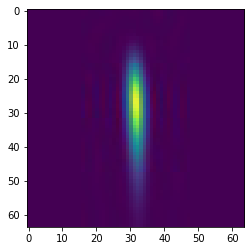

In [9]:
from PIL import Image
im = Image.open(os.path.join(datpath_train,"frog0.jpg"))
img=np.array(im)
plt.imshow(img)
print("Image shape:",img.shape)

The images contain RGB information. The RGB colors will be converted to gray scale using the function `rgb2gray`. 

New image shape: (64, 64)


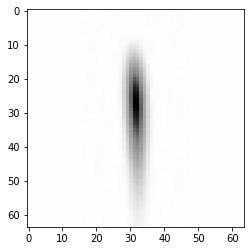

In [10]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

print("New image shape:",rgb2gray(img).shape)
plt.imshow(rgb2gray(img),'binary')
plt.show()

Features will be created from images. The shape of the feature is  
(number of the images) x (height) x (width) x (depth)


In [25]:
X_train=np.zeros((len(rand_dat_num_list),64,64,1))

for i, idx in enumerate(rand_dat_num_list):
    img = Image.open(os.path.join(datpath_train,"frog%d.jpg"%idx))
    img=rgb2gray(np.array(img))
    img=img-img.min() # subtract the minimum value
    img=img/img.max() # normalization
    X_train[i,:,:,0]=img

print("X_train shape:",X_train.shape)

X_train shape: (1600, 64, 64, 1)


# Training a convolutional neural network model

## Building and tuning a model using cross validation

In [12]:
from keras import layers 
from keras import models
from keras import activations
from keras import optimizers
from keras import callbacks
from keras import initializers

def build_model():
    model = models.Sequential()

    model.add(layers.Conv2D(32,(3,3),activation='relu', kernel_initializer='he_uniform',input_shape = (64,64,1)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_uniform'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_uniform'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu',kernel_initializer='he_uniform'))
    model.add(layers.Dense(2,activation='linear',kernel_initializer='he_uniform',))

    model.compile(loss='mse', optimizer=optimizers.Adam(lr=1e-4), metrics=['mae'])
    
    return model

build_model().summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 6, 128)        

You can modify and tune the model shown above. You can check the performance of your model using cross validation. The function `cross_validation` allows you to do it. In the cross validation process, standardization is also performed.

In [0]:
def cross_validation(k,num_epochs,train_data,train_targets):
# k : number of folds
# num_epochs: number of epochs
# train_data, train_targets: training data. This will be split into the partial training data and validation data. 
    m = train_data.shape[0] # number of training data 
    num_val_samples = len(dat_num_list) // k # number of validation data

    all_scores= [] # list for saving the final validation MAE value
    all_mae_histories_train = [] # list for saving MAE history
    all_mae_histories_val = [] # list for saving MAE history
    
    for i in range(k): # start cross validation
        print('processing fold #', i+1) 
        val_data = train_data[i * num_val_samples: (i+1)*num_val_samples] # prepare a validation set
        val_targets = train_targets[i * num_val_samples: (i+1)*num_val_samples] # prepare a validation set (target)
        
        partial_train_data = np.concatenate(
          [train_data[:i*num_val_samples], train_data[(i+1)*num_val_samples:]],
          axis=0) # prepare a training dataset
        
        partial_train_targets = np.concatenate(
          [train_targets[:i*num_val_samples], train_targets[(i+1)*num_val_samples:]],
          axis=0) # prepare a training target

        partial_train_targets, ave_ptrain, std_ptrain = standardization(partial_train_targets) # standardization for the training set
        val_targets = (val_targets - ave_ptrain)/std_ptrain # standardization for the validation set using the mean and standard deviation of the training set

        modelNN = build_model() # build the Keras model (already compiled)

        csv_logger = callbacks.CSVLogger('training_cv_%d.log'%i) # make a log file for progress of the training
        reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10) 
 #       early_stopping=callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=1)

        history = modelNN.fit(partial_train_data,
                              partial_train_targets, 
                              epochs = num_epochs,
                              batch_size=20,
                              validation_data=(val_data,val_targets),
#                              callbacks=[csv_logger,reduce_lr,early_stopping],
                              callbacks=[csv_logger,reduce_lr],
                              verbose = 1) # train the model 

        val_mse, val_mae = modelNN.evaluate(val_data, val_targets, verbose = 0) # get mse and mae scores for the validation set
        all_scores.append(val_mae) # append to the list 

        all_mae_histories_train.append(history.history['mean_absolute_error']) # get mae history
        all_mae_histories_val.append(history.history['val_mean_absolute_error']) # get mae history

    return all_scores, all_mae_histories_train, all_mae_histories_val, modelNN

In [169]:
k=4
num_epochs=100
results = cross_validation(k,num_epochs,X_train,y_train)

processing fold # 1
Train on 1200 samples, validate on 400 samples
Epoch 1/100
1200/1200 [==============================] - 10s 9ms/step - loss: 0.3425 - mean_absolute_error: 0.4387 - val_loss: 0.0824 - val_mean_absolute_error: 0.2250
Epoch 2/100
1200/1200 [==============================] - 1s 518us/step - loss: 0.1048 - mean_absolute_error: 0.2480 - val_loss: 0.0211 - val_mean_absolute_error: 0.1092
Epoch 3/100
1200/1200 [==============================] - 1s 499us/step - loss: 0.0560 - mean_absolute_error: 0.1829 - val_loss: 0.0090 - val_mean_absolute_error: 0.0728
Epoch 4/100
1200/1200 [==============================] - 1s 513us/step - loss: 0.0378 - mean_absolute_error: 0.1526 - val_loss: 0.0099 - val_mean_absolute_error: 0.0759
Epoch 5/100
1200/1200 [==============================] - 1s 504us/step - loss: 0.0278 - mean_absolute_error: 0.1292 - val_loss: 0.0065 - val_mean_absolute_error: 0.0640
Epoch 6/100
1200/1200 [==============================] - 1s 493us/step - loss: 0.0236 - m

In [170]:
print("MAE averaged over all folds (validation set):",np.average(results[0]))

MAE averaged over all folds (validation set): 0.025293273739516734


The performance of the model will be visualized in the next cell.

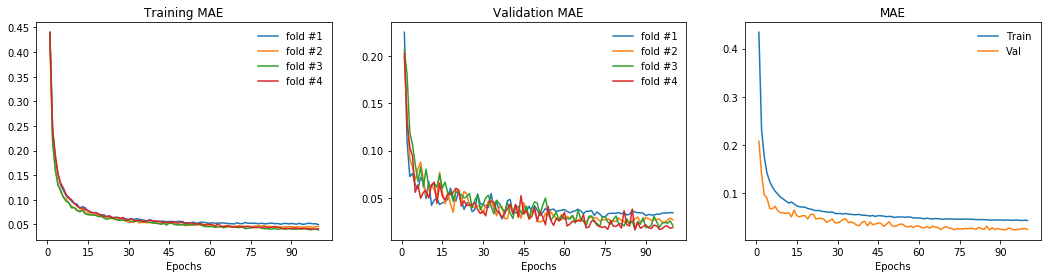

In [171]:
mae_average_train=np.zeros_like(results[1][0])
mae_average_val=np.zeros_like(results[2][0])
epochs=np.linspace(1,num_epochs,num_epochs)

plt.figure(figsize=(18,4))
plt.subplot(131)
plt.title("Training MAE")

for i in range(len(results[1])):
    plt.plot(epochs,np.array(results[1][i]), label = 'fold #%d'%(i+1) )
    mae_average_train=mae_average_train + np.array(results[1][i])/len(results[1])
plt.legend(frameon = False)
plt.xlabel("Epochs")
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))

plt.subplot(132)
plt.title("Validation MAE")
for i in range(len(results[2])):
    plt.plot(epochs,np.array(results[2][i]), label = 'fold #%d'%(i+1) )
    mae_average_val=mae_average_val + np.array(results[2][i])/len(results[2])
plt.legend(frameon = False)
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel("Epochs")

plt.subplot(133)
plt.title("MAE")
plt.plot(epochs,mae_average_train, label = 'Train')
plt.plot(epochs,mae_average_val, label = 'Val')
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
plt.legend(frameon = False)
plt.xlabel("Epochs")

plt.show()

Below is an expanded version.

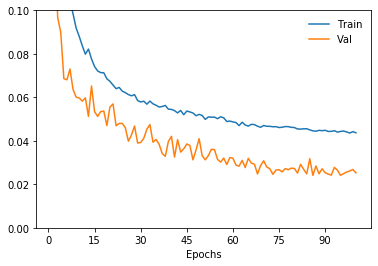

In [172]:
plt.plot(epochs,mae_average_train, label = 'Train')
plt.plot(epochs,mae_average_val, label = 'Val')
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
plt.legend(frameon = False)
plt.xlabel("Epochs")
plt.ylim([0,0.1])
plt.show()

In [173]:
for j in range(k):
  print("\nFOLD %d----"%j)
  print(pd.read_csv("training_cv_%d.log"%j).tail(15))


FOLD 0----
    epoch      loss  mean_absolute_error  val_loss  val_mean_absolute_error
85     85  0.004381             0.050042  0.001796                 0.035127
86     86  0.004502             0.051376  0.001736                 0.034479
87     87  0.004497             0.051996  0.001724                 0.034415
88     88  0.004267             0.050745  0.001697                 0.034044
89     89  0.004570             0.051823  0.001444                 0.031388
90     90  0.004474             0.050931  0.001562                 0.032628
91     91  0.004376             0.050292  0.001509                 0.032086
92     92  0.004564             0.052088  0.001509                 0.031931
93     93  0.004263             0.050067  0.001614                 0.033122
94     94  0.004325             0.050458  0.001579                 0.032711
95     95  0.004645             0.051858  0.001700                 0.034065
96     96  0.004643             0.052051  0.001706                 0.034146


## Final training

In [0]:
from sklearn.model_selection import train_test_split

partial_train_data, val_data, partial_train_targets, val_targets = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

partial_train_targets, ave_ptrain, std_ptrain = standardization(partial_train_targets) # standardization for the training set
val_targets = (val_targets - ave_ptrain)/std_ptrain # standardization for the validation set using the mean and standard deviation of the training set

model = build_model() # build the Keras model (already compiled)

csv_logger = callbacks.CSVLogger('training_final_%d.log'%i)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
early_stopping=callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1) # early stopping

history = model.fit(partial_train_data,
                      partial_train_targets, 
                      epochs = 100,
                      batch_size=20,
                      validation_data=(val_data,val_targets),
                      callbacks=[csv_logger,reduce_lr,early_stopping],
                      verbose = 1) # train the model 

model.save("model.h5")

Train on 1280 samples, validate on 320 samples
Epoch 1/100
1280/1280 [==============================] - 11s 9ms/step - loss: 0.4317 - mean_absolute_error: 0.4926 - val_loss: 0.1590 - val_mean_absolute_error: 0.2872
Epoch 2/100
1280/1280 [==============================] - 1s 507us/step - loss: 0.1381 - mean_absolute_error: 0.2811 - val_loss: 0.0551 - val_mean_absolute_error: 0.1800
Epoch 3/100
1280/1280 [==============================] - 1s 491us/step - loss: 0.0810 - mean_absolute_error: 0.2153 - val_loss: 0.0534 - val_mean_absolute_error: 0.1786
Epoch 4/100
1280/1280 [==============================] - 1s 490us/step - loss: 0.0561 - mean_absolute_error: 0.1784 - val_loss: 0.0165 - val_mean_absolute_error: 0.1041
Epoch 5/100
1280/1280 [==============================] - 1s 486us/step - loss: 0.0382 - mean_absolute_error: 0.1498 - val_loss: 0.0174 - val_mean_absolute_error: 0.1114
Epoch 6/100
1280/1280 [==============================] - 1s 511us/step - loss: 0.0310 - mean_absolute_error: 

In [175]:
history.history.keys()

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error', 'lr'])

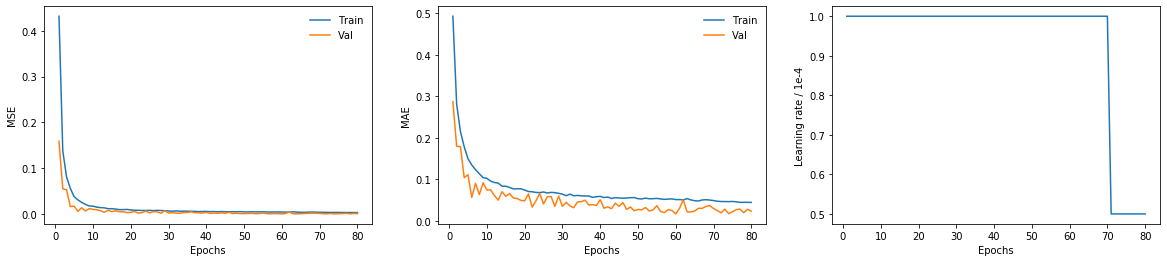

In [176]:
num_epochs=len(history.history['loss'])
epochs=np.linspace(1,num_epochs,num_epochs)

plt.figure(figsize=(20,4))
plt.subplot(131)
plt.plot(epochs,history.history['loss'],label='Train')
plt.plot(epochs,history.history['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(frameon=False)

plt.subplot(132)
plt.plot(epochs,history.history['mean_absolute_error'],label='Train')
plt.plot(epochs,history.history['val_mean_absolute_error'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend(frameon=False)

plt.subplot(133)
plt.plot(epochs,np.array(history.history['lr'])*1e4)
plt.xlabel('Epochs')
plt.ylabel('Learning rate / 1e-4')
plt.show()

# Test data


## Preparation of test data

Test images will be created. The pulse parameters (pulse width and chirp parameter b) are randomly determined.

Start preparing test images...
Data 0 --
b = 0.006888 [rad/fs^2]
FWHM = 25.159088 fs


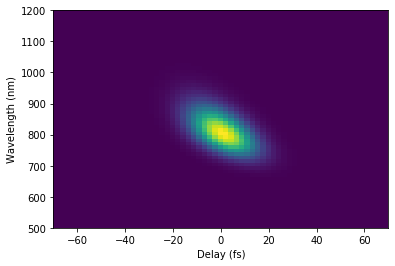

Data 1 --
b = -0.007313 [rad/fs^2]
FWHM = 26.948675 fs


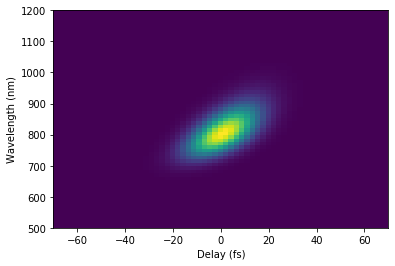

Data 2 --
b = 0.009121 [rad/fs^2]
FWHM = 28.956550 fs


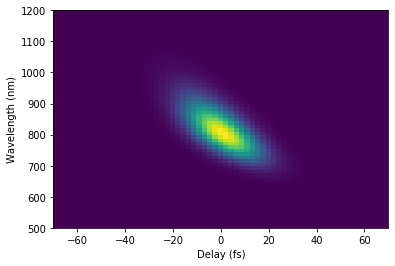

Data 3 --
b = -0.005241 [rad/fs^2]
FWHM = 20.884585 fs


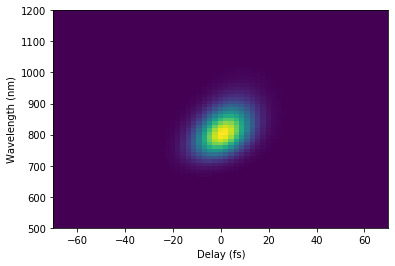

Finished...


In [17]:
import random
from scipy import integrate
from frog_func import * # functions for simulating FROG traces

num_test=4
X_test=[]
y_test=[]
print("Start preparing test images...")

for i in range(num_test):
  random.seed(i)
  b=random.uniform(-0.01,0.01)
  fwhm=random.uniform(10,30)

  print("Data %d --"%i)
  print("b = %f [rad/fs^2]"%b)
  print("FWHM = %f fs"%fwhm)

  params={
      'e0':1,
      'fwhm':fwhm, # FWHM / fs
      'b':b*1e30,  # chirp  rad/s^2
      'wl0':800, # central wavelength / nm
      'num_delay_steps':64, # number of delay steps
      'num_wl_steps':64, # number of wavelength steps
      'tau_min':-70, # delay range (min) /fs
      'tau_max':70, # delay range (max) /fs 
      'wl_min':500, # scan wavelength range (min) /nm
      'wl_max':1200, # scan wavelength range (max) /nm
      'tmin':-200, # integral range /fs
      'tmax':200 # integral range /fs
          }

  sig, delay, wl = frog_signal(params)

  img=np.array(sig) # convert to numpy array 
  img=img.reshape(params['num_delay_steps'],params['num_delay_steps']).T # reshaping
  img=img-np.min(img) # subtract minimum
  img=img/np.max(img) # normalization

  X_test.append(img)
  y_test.append([fwhm,b])

  plt.pcolor(delay,wl,img)
  plt.xlabel('Delay (fs)')
  plt.ylabel('Wavelength (nm)')
  plt.imsave('frog_test%d.jpg'%i,img,cmap='jet')
  plt.show() 

print("Finished...")

In [18]:
temp_X=X_test
X_test=np.array(temp_X).reshape(-1,64,64,1)
X_test.shape

temp_y=y_test
y_test=np.array(temp_y)
y_test

array([[ 2.51590881e+01,  6.88843703e-03],
       [ 2.69486747e+01, -7.31271512e-03],
       [ 2.89565497e+01,  9.12068544e-03],
       [ 2.08845845e+01, -5.24070746e-03]])

## Prediction for the test data

In [19]:
#from keras.models import load_model
#model = load_model('model.h5', compile=False)

model.predict(X_test)

array([[ 0.7989652 ,  1.2383854 ],
       [ 1.0138714 , -1.3554921 ],
       [ 1.283822  ,  1.6501558 ],
       [ 0.17244451, -1.0583658 ]], dtype=float32)

In [0]:
y_pred=np.zeros_like(y_test)

#partial_train_data, val_data, partial_train_targets, val_targets = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
#partial_train_targets, ave_ptrain, std_ptrain = standardization(partial_train_targets) # standardization for the training set

y_pred[:,0]=model.predict(X_test)[:,0]*std_ptrain[0]+ave_ptrain[0]
y_pred[:,1]=model.predict(X_test)[:,1]*std_ptrain[1]+ave_ptrain[1]

In [42]:
print("FWHM (test data):",y_test[:,0])
print("Predicted FWHM:",y_pred[:,0])
print("Difference (real - pred.):",y_test[:,0]-y_pred[:,0])

print("\nb (test data):",y_test[:,1])
print("Predicted b:",y_pred[:,1])
print("Difference (real - pred.):",y_test[:,1]-y_pred[:,1])

FWHM (test data): [25.15908806 26.94867474 28.95654974 20.88458451]
Predicted FWHM: [24.89383316 26.16125488 27.75330353 21.19889259]
Difference (real - pred.): [ 0.2652549   0.78741986  1.20324621 -0.31430809]

b (test data): [ 0.00688844 -0.00731272  0.00912069 -0.00524071]
Predicted b: [ 0.00738103 -0.0079288   0.00981142 -0.00617507]
Difference (real - pred.): [-0.00049259  0.00061609 -0.00069073  0.00093437]


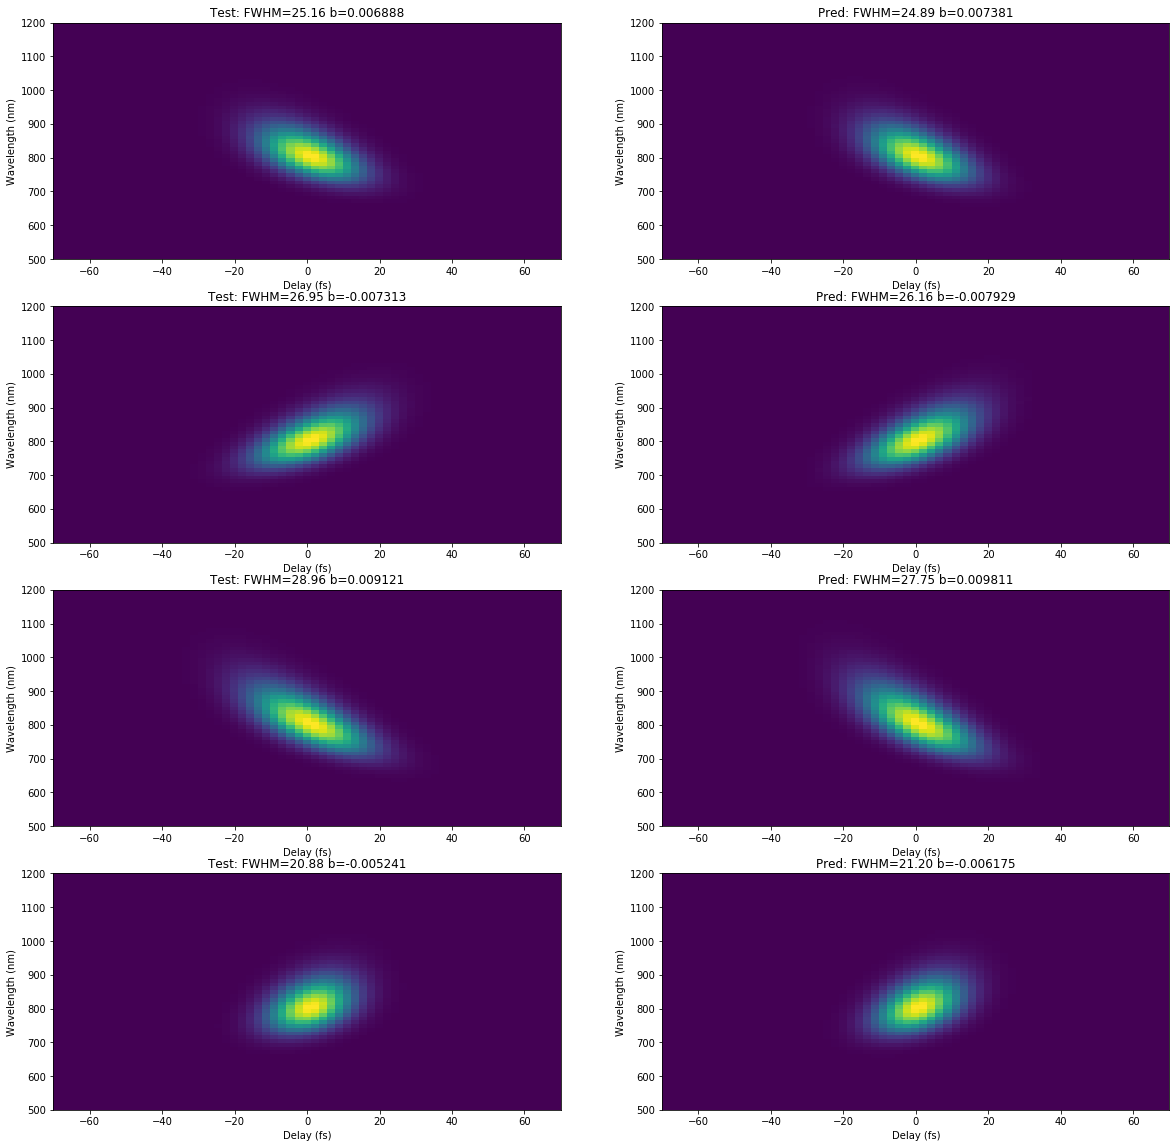

In [49]:
plt.figure(figsize=(20,20))

for j in range(num_test):

  # TEST DATA
  fwhm , b = y_test[j]
  
  params={
      'e0':1,
      'fwhm':fwhm, # FWHM / fs
      'b':b*1e30,  # chirp  rad/s^2
      'wl0':800, # central wavelength / nm
      'num_delay_steps':64, # number of delay steps
      'num_wl_steps':64, # number of wavelength steps
      'tau_min':-70, # delay range (min) /fs
      'tau_max':70, # delay range (max) /fs 
      'wl_min':500, # scan wavelength range (min) /nm
      'wl_max':1200, # scan wavelength range (max) /nm
      'tmin':-200, # integral range /fs
      'tmax':200 # integral range /fs
          }

  sig, delay, wl = frog_signal(params)

  img=np.array(sig) # convert to numpy array 
  img=img.reshape(params['num_delay_steps'],params['num_delay_steps']).T # reshaping
  img=img-np.min(img) # subtract minimum
  img=img/np.max(img) # normalization

  plt.subplot(num_test,2,2*j+1)
  plt.pcolor(delay,wl,img)
  plt.title("Test: FWHM=%0.2f b=%0.6f"%(fwhm,b))
  plt.xlabel('Delay (fs)')
  plt.ylabel('Wavelength (nm)')

  # PREDICTION
  fwhm , b = y_pred[j]

  params={
      'e0':1,
      'fwhm':fwhm, # FWHM / fs
      'b':b*1e30,  # chirp  rad/s^2
      'wl0':800, # central wavelength / nm
      'num_delay_steps':64, # number of delay steps
      'num_wl_steps':64, # number of wavelength steps
      'tau_min':-70, # delay range (min) /fs
      'tau_max':70, # delay range (max) /fs 
      'wl_min':500, # scan wavelength range (min) /nm
      'wl_max':1200, # scan wavelength range (max) /nm
      'tmin':-200, # integral range /fs
      'tmax':200 # integral range /fs
          }

  sig, delay, wl = frog_signal(params)

  img=np.array(sig) # convert to numpy array 
  img=img.reshape(params['num_delay_steps'],params['num_delay_steps']).T # reshaping
  img=img-np.min(img) # subtract minimum
  img=img/np.max(img) # normalization

  plt.subplot(num_test,2,2*j+2)
  plt.pcolor(delay,wl,img)
  plt.title("Pred: FWHM=%0.2f b=%0.6f"%(fwhm,b))
  plt.xlabel('Delay (fs)')
  plt.ylabel('Wavelength (nm)')

plt.show()

# Summary

In the present study, it is shown that the convolutional neural network model can extract the characteristics of laser pulses, i.e., the pulse width and temporal chirp parameters, from the PG-FROG traces that are numerically simulated. It takes time to repeat training and tuning a model, but once these processes are finished, the required time for extracting information is much shorter than the time required when using the ordinary retrieval method.
 